#Errors in serial dilution: why would dispensing technology matter?

####[Sonya M. Hanson and John D. Chodera](http://www.choderalab.org/) Computational Biology Program, Memorial Sloan Kettering Cancer Center

In a recent paper by Ekins et al, [Dispensing Processes Impact Apparent Biological Activity as Determined by Computational and Statistical Analyses. PLoS ONE 8(5): e62325, 2013](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0062325), a large discrepancy was observed in IC50 assay values in which either a LabCyte Echo acoustic dispensing unit or a Tecan Genesis liquid handling workstation were used in performing the assays.  [Should we also reference nature blogs and in the pipeline posts here?]

#<span style="color:blue">insert quote here</span>

This discrepancy may be due to any number of factors, but one of the main features of the Echo is its direct dispensing technology that allows a dilution series over several orders of magnitude in concentration to be created directly without the need for serial dilution.

#<span style="color:blue">insert figure here</span>

###Here we experiment with some simple python models to see what could be the source of these discrepencies.

### 0. Define assay setup

In [39]:
# import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
from scipy.interpolate import interp1d
%pylab inline
sns.set(style='white')
sns.set_context('talk')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Our general assay setup is of 8 points of 100 uL each in our dilution series (including the original concentration), starting with an initial concentration of 10 mM in DMSO stock. Each point will be diluted be a factor 2 dilution of the previous step.

#<span style="color:blue">insert figure here</span>

Define number of points in dilution series (including original stock):

In [40]:
ndilutions = 8

Define original volume as 100 µL:

In [41]:
V0 = 100e-6

Define stock concentration as 10 mM:

In [42]:
C0 = 10e-3

Define specific parameters of the dilution series (transferring 50 µL into 50 µL buffer at each step):

In [43]:
Vtransfer = 50e-6
Vbuffer = 50e-6

Define dilution series function:

In [44]:
def dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions):
    # Initialize concentrations and volumes with zero vectors with C0 and V0 as first value
    concentrations = numpy.zeros([ndilutions], numpy.float64)
    volumes = numpy.zeros([ndilutions], numpy.float64)
    concentrations[0] = C0
    volumes[0] = V0
    
    # and Vbuffer as initial volume for all but first.
    for n in range(1,ndilutions):
        volumes[n] = Vbuffer
        
    # Create dilution series.
    for n in range(1,ndilutions):
        concentrations[n] = concentrations[n-1] * Vtransfer / (Vtransfer + Vbuffer)
        volumes[n] += Vtransfer
        volumes[n-1] -= Vtransfer
        
    # Remove Vtransfer from last.
    volumes[ndilutions-1] -= Vtransfer
    
    return [volumes, concentrations]

In [45]:
[ideal_volumes, ideal_concentrations] = dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions)

In [46]:
print "Thus we now have an %s part dilution series from %s M to %s M." % (ndilutions, C0, ideal_concentrations[-1])

Thus we now have an 8 part dilution series from 0.01 M to 7.8125e-05 M.


Let's plot it!

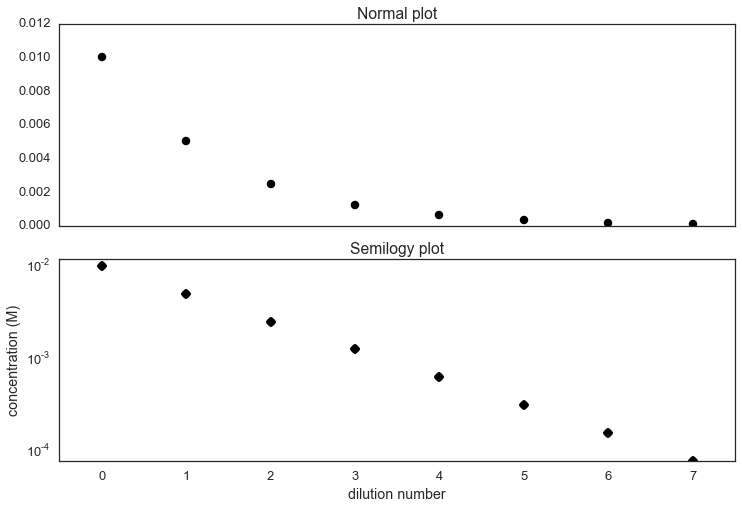

In [47]:
f, (ax1,ax2) = plt.subplots(2,1,sharex=True)
ax1.scatter(range(ndilutions), ideal_concentrations, lw=4)
ax1.set_title("Normal plot")
ax2.semilogy(range(ndilutions), ideal_concentrations,'ko')
ax2.set_title("Semilogy plot")
plt.xlabel('dilution number')
plt.ylabel('concentration (M)')
ax1.axis([- 0.5, ndilutions - 0.5, 0.0, C0 * 1.2])
ax2.axis([- 0.5, ndilutions - 0.5, 0.0, C0 * 1.2])
f.tight_layout()

First we'll model how a human or a liquid-handling robot does a serial dilution, then we'll model how direct dispense technology does for the same dilution series.

### 1. Dilution and dispensing by a liquid-handling robot.

Real liquid-handling robots can't transfer the specified volume exactly. Each transfer operation has some (a) inaccuracy (modeled as a constant bias factor for all dispensing operations) and (b) imprecision (random error associated with each volume transfer). We'll ignore other contributions to error, such as compound stickiness, insolubility, etc.

Suppose we generate this dilution series using a Tecan Genesis robot used in the assay.

Published specs for standard bias and error for the Genesis (which appears to be no longer produced) are not available, so we'll use data for a Beckman NX/FX span-8 instead:

[inaccuracy/imprecision data for Biomek NX/FX](https://www.beckmancoulter.com/wsrportal/bibliography?docname=BR-10150B.pdf)


#<span style="color:blue">insert chart from link here</span>

Define pipetting error function for the genesis:

In [48]:
def tecan_genesis_pipetting_model(volume):
    # Assume published imprecision/inaccuracy for Beckman Biomek NX/FX span-8.
    
    imprecision_function = interp1d(
        [0.5e-6, 1e-6, 5e-6, 10e-6, 50e-6, 100e-6, 250e-6, 950e-6],
        [0.10, 0.07, 0.05, 0.05, 0.05, 0.05, 0.02, 0.01]) # published imprecision for Beckman NX/FX span-8
    inaccuracy_function = interp1d(
        [0.5e-6, 1e-6, 100e-6, 250e-6, 900e-6],
        [0.05, 0.03, 0.03, 0.02, 0.01]) # published inaccuracy for Beckman NX/FX span-8
    
    return [inaccuracy_function(volume), imprecision_function(volume)]    

Just for reference, this is what the ideal pipetting model looks like in comparison:

In [49]:
def ideal_pipetting_model(volume):

    imprecision_function = interp1d(
        [0.5e-6, 1e-6, 5e-6, 10e-6, 50e-6, 100e-6, 250e-6, 950e-6], 
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    inaccuracy_function = interp1d(
        [0.5e-6, 1e-6, 100e-6, 250e-6, 900e-6], 
        [0.0, 0.0, 0.0, 0.0, 0.0])
    
    return [inaccuracy_function(volume), imprecision_function(volume)]    

#<span style="color:blue">Add better description of what is changing.</span>

Now we'll apply this error to our dilution series:

In [68]:
# define ROBOT_dilution_series function
def ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, pipetting_model):
    
    # use pipetting error function
    [transfer_inaccuracy, transfer_imprecision] = pipetting_model(Vtransfer)    
            
    # define (b) imprecision of volume transfer operations (including initial volumes)
    transfer_bias = transfer_inaccuracy * normal()
    
    # Initialize concentrations and volumes with zero vectors with C0 and V0 as first value
    actual_concentrations = numpy.zeros([ndilutions], numpy.float64)
    actual_volumes = numpy.zeros([ndilutions], numpy.float64)
    actual_concentrations[0] = C0
    actual_volumes[0] = V0
    
    # and Vbuffer as initial volume for all but first.
    Vbuffer_actual = Vbuffer * ((1+transfer_bias) + transfer_imprecision*normal())
    for n in range(1,ndilutions):
        actual_volumes[n] = Vbuffer_actual
    
    # Create dilution series.
    for n in range(1,ndilutions):
        Vtransfer_actual = Vtransfer * ((1+transfer_bias) + transfer_imprecision*normal())
        actual_concentrations[n] = \
            actual_concentrations[n-1] * Vtransfer_actual / (Vtransfer_actual + Vbuffer_actual)
        actual_volumes[n] += Vtransfer_actual
        actual_volumes[n-1] -= Vtransfer_actual
    Vtransfer_actual = Vtransfer * ((1+transfer_bias) + transfer_imprecision*normal())
    
    # Remove Vtransfer from last.
    actual_volumes[ndilutions-1] -= Vtransfer_actual
    
    return [actual_volumes, actual_concentrations]

In [69]:
[actual_volumes, actual_concentrations] = \
    ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)

Let's plot it!

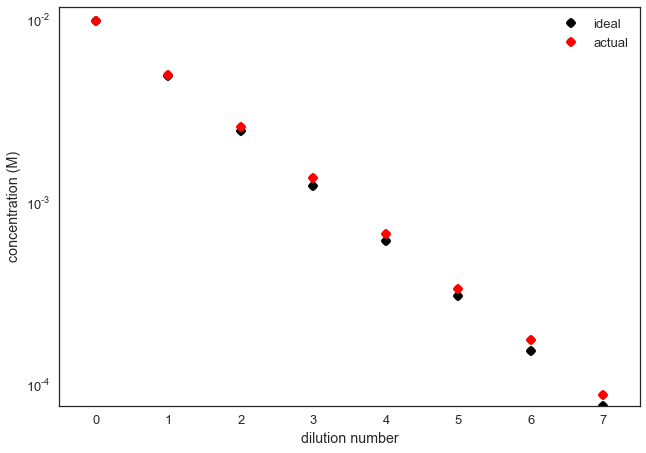

In [52]:
plt.semilogy(range(ndilutions), ideal_concentrations, 'ko', range(ndilutions), actual_concentrations, 'ro');
plt.xlabel('dilution number');
plt.ylabel('concentration (M)');
plt.legend(['ideal','actual']);
plt.axis([-0.5, ndilutions - 0.5, 0.0, C0 * 1.2]);

What if we plot the relative errors in concentration, volume, and total quantity of compound per well?

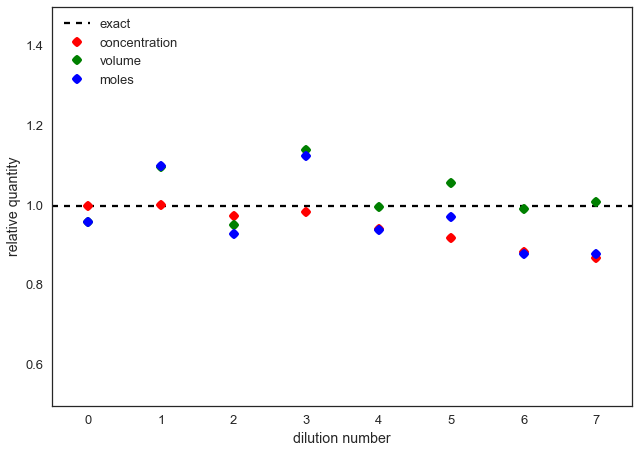

In [73]:
plt.plot([-0.5, ndilutions], [1, 1], 'k--')
plt.plot(range(ndilutions), actual_concentrations / ideal_concentrations, 'ro', \
         range(ndilutions), actual_volumes / ideal_volumes, 'go', \
         range(ndilutions), (actual_volumes*actual_concentrations)/(ideal_volumes*ideal_concentrations), 'bo')
plt.legend(['exact', 'concentration', 'volume', 'moles'], loc='upper left')
plt.axis([-0.5, ndilutions - 0.5, 0.5, 1.5])
plt.ylabel('relative quantity')
plt.xlabel('dilution number')

This is kind of all over the place, with no obvious trend, but what if we repeat the experiment many times? Then we can estimate the coefficient of variation (CV) for each dilution number.

Let's repeat the experiment 5000 times:

In [76]:
nreplicates = 5000

actual_volumes_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
actual_concentrations_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)

for replicate in range(nreplicates):
    [actual_volumes_replicate, actual_concentrations_replicate] = \
        ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)
        
    actual_volumes_n[replicate,:] = actual_volumes_replicate
    actual_concentrations_n[replicate,:] = actual_concentrations_replicate

Now let's use this to compute the CV, using numpy.std, which calculates the standard deviation:

In [77]:
volumes_cv = (actual_volumes_n / ideal_volumes).std(0)
concentrations_cv = (actual_concentrations_n / ideal_concentrations).std(0)
quantity_cv = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).std(0)

And let's plot it!

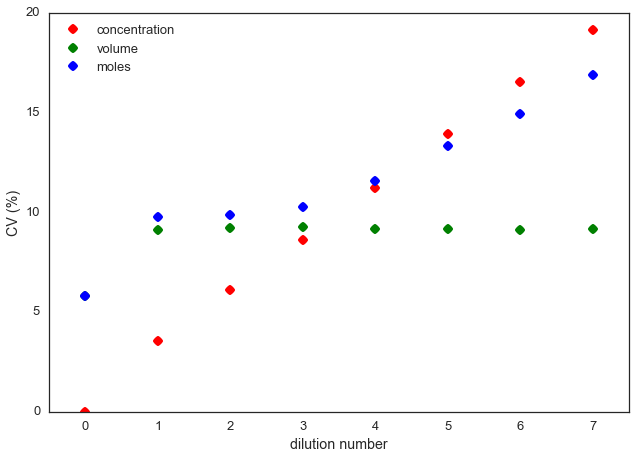

In [78]:
plt.plot(range(ndilutions), concentrations_cv*100, 'ro', \
         range(ndilutions), volumes_cv*100, 'go', \
         range(ndilutions), quantity_cv*100, 'bo');
plt.xlabel('dilution number');
plt.ylabel('CV (%)');
plt.xlim([-0.5, ndilutions - 0.5])
plt.legend(['concentration', 'volume', 'moles'], loc='upper left');

So these are the errors we're getting just by looking at inaccuracy and imprecision. Notice how the concentration error creeps up to almost 20% in the last sample?

But is there a bias at all as a result of this?

Let's look at the mean of all these values for this 5000 replicate test.

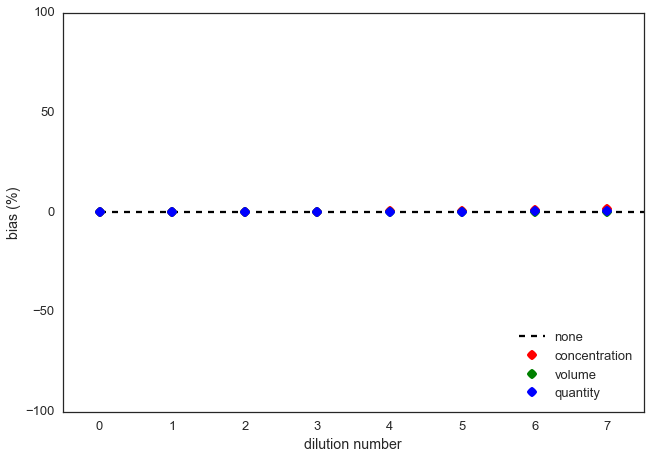

In [85]:
# Compute relative bias.
volumes_bias = (actual_volumes_n / ideal_volumes).mean(0) - 1
concentrations_bias = (actual_concentrations_n / ideal_concentrations).mean(0) - 1
quantity_bias = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).mean(0)- 1

# Plot relative biases.
x = numpy.arange(ndilutions)
plt.plot([0, ndilutions], [0, 0], 'k--', x, concentrations_bias*100, 'ro', \
     x, volumes_bias*100, 'go', x, quantity_bias*100, 'bo');
plt.xlabel('dilution number');
plt.ylabel('bias (%)');
plt.legend(['none','concentration', 'volume', 'quantity'], loc='lower right');
plt.axis([-0.5, ndilutions - 0.5, -100, 100]);

Despite some creep in the eror, it doesn't seem like there's a tremendous bias.

###But wait!

###We still have one more source of error to add!

In an interesting paper by Dong et al, [The use of a dual dye photometric calibration method to identify possible sample dilution from an automated multichannel liquid-handling system. J. Lab. Autom. 11(2): 2006](http://dx.doi.org/10.1016/j.jala.2006.02.005), they reveal that the system liquid on the inside of the steel fixed tips of the Tecan Genesis can result in significant dilution errors.

In [ ]:
#add in dilution effect, new function, new reference, new quote
 # Account for dilution effect.
    from scipy.interpolate import interp1d
    x = numpy.array([20, 200]) * 1e-6 # L
    y = numpy.array([-0.0630, -0.0496]) # doi:10.1016/j.jala.2006.02.005
    dilution_function = interp1d(x, y)
    

In [32]:
#more later

### 2. Dispensing by direct dispensing with the LabCyte Echo.

0 - remove comments
1 - finish fixing functions (reread GRC notebook, compared to this...)
2 - finish adding rest of notebook - actually a dilution error - quote that one paper
3 - add in figures

### 3. How do IC50 estimates between these compare?

### 4. At the Chodera Lab we use the D300 for our direct dispensing needs!